In [1]:
!git clone https://github.com/AvonYangXX1/AMPLify-Feedback.git
# !pip install Levenshtein
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics
# from Levenshtein import distance as lev
import pandas as pd

fatal: destination path 'AMPLify-Feedback' already exists and is not an empty directory.


In [2]:
def create_generator():
    origin_generator = tf.keras.models.load_model('AMPLify-Feedback/model_weights/PeptideGenerator_new.keras')
    inputs = tf.keras.layers.Input(shape=(326),name="SeqInput")
    x = tf.keras.layers.Dense(2, activation="tanh")(inputs)
    x = origin_generator(x)
    new_generator = tf.keras.models.Model(inputs, x)
    return new_generator

In [3]:
def create_oracle():
    inputs0 = tf.keras.layers.Input((190,43),name="SeqInput")
    inputs1 = tf.keras.layers.Input((326,),name="StateInput")
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_0")(inputs0) # kernel_size=5 works well
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_1")(x) # Just two layers work better
    x = tf.keras.layers.Flatten(name="Flatten_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnSeqDense_0")(x)
    x = tf.keras.layers.Concatenate(axis=1, name="Concat")([x, inputs1])
    x = tf.keras.layers.Dense(1024, activation="relu", name="LearnConcatDense_0")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnConcatDense_1")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_1")(x)
    x = tf.keras.layers.Dense(1, activation="linear", name="Output")(x)
    model = tf.keras.models.Model([inputs0, inputs1], x, name="MICPredictor")
    return model

In [4]:
oracle = create_oracle()
path = "AMPLify-Feedback/model_weights/MICPredictor"
for i, layer in enumerate(oracle.layers):
    weights = np.load(f"{path}/layer_{i}_weights.npy", allow_pickle=True)
    layer.set_weights(weights)

In [5]:
aa_vocal = np.load("AMPLify-Feedback/model_weights/SeqTV_vocal.npy")
pep_decoder = tf.keras.layers.StringLookup(vocabulary=aa_vocal[1:], invert=True, oov_token='')
species_vocal = np.load("AMPLify-Feedback/model_weights/SpeciesTV_vocal.npy")
species_decoder = tf.keras.layers.StringLookup(vocabulary=species_vocal[1:], invert=True, oov_token='')

In [6]:
def generate_sequences(generator, bacteria):
    generated_sequences = generator.predict(bacteria, verbose=0)
    return onehot2seq(generated_sequences)

In [7]:
def onehot2seq(onehot):
  decoded_sequences = []
  chars_array = pep_decoder(tf.math.argmax(onehot, axis=2)).numpy().astype('str')
  decoded_sequences += ["".join(chars) for chars in chars_array]
  return decoded_sequences

In [8]:
@tf.function
def compute_gradient(oracle, bacteria, generator_optimizer):
    bacteria = tf.convert_to_tensor(bacteria, np.float64)
    with tf.GradientTape() as gen_tape:
        gen_tape.watch(bacteria)
        generated_onehot = generator(bacteria, training=True)
        generator_loss = tf.reduce_mean(oracle([generated_onehot, bacteria]))
    gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return generated_onehot

In [9]:
def variability_metrics(sequences, aa_vocal, pep_decoder):
  total_lev = 0
  index = 0
  for s1 in range(len(sequences)):
                for s2 in range(s1+1,len(sequences)):
                        total_lev += lev(sequences[s1],sequences[s2])
                        index += 1
  return total_lev/index

In [10]:
def display(parameters):
  for p in list(parameters.keys()):
    plt.plot(range(len(parameters[p])), parameters[p], linestyle='-', label = p)
  plt.legend(loc = "upper right")
  plt.ylabel("Value")
  plt.xlabel("Iteration index")
  plt.title("Performances with the feedback loop")
  plt.show()

In [11]:
def RL_loop(generator, oracle, aa_vocal, pep_decoder, target):
  average_mic_train, min_mic_train, max_mic_train, median_mic_train, levenstein  = [], [], [], [], []
  generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  for i in range (n_iter_max) :
    #Sequences prediction and gradient computation
    # noise, num_sequences, bacteria = hallucination_mapping(n_bins, target)
    generated_onehot = compute_gradient(oracle, bacteria, generator_optimizer)
    generated_sequences = onehot2seq(generated_onehot)

    #Oracle results and statistics
    MIC = oracle([generated_onehot, bacteria])
    average_mic_train += [np.mean(MIC)]
    min_mic_train += [np.min(MIC)]
    max_mic_train += [np.max(MIC)]
    median_mic_train += [np.median(MIC)]

    print(f"Iter {i+1}/{n_iter_max}; Average MIC {np.mean(MIC):.4f}")

  return generator, average_mic_train, min_mic_train, max_mic_train, median_mic_train

In [12]:
latent_dim = 2
n_iter_max = 40
# n_bins = 101
num_sequences = 10000

np.random.seed(8701)
bacteria = []
for i in range(num_sequences):
    bacterium = np.zeros(326)
    bacterium[np.random.randint(0, 326)]=1
    bacteria.append([bacterium])
bacteria = np.concatenate(bacteria, axis=0)

generator = create_generator()
generator, average_mic_train, min_mic_train, max_mic_train, median_mic_train = RL_loop(generator, oracle, aa_vocal, pep_decoder, bacteria)

Iter 1/40; Average MIC 4.3450
Iter 2/40; Average MIC 4.1503
Iter 3/40; Average MIC 4.0123
Iter 4/40; Average MIC 3.8658
Iter 5/40; Average MIC 3.7520
Iter 6/40; Average MIC 3.6892
Iter 7/40; Average MIC 3.6097
Iter 8/40; Average MIC 3.5436
Iter 9/40; Average MIC 3.4598
Iter 10/40; Average MIC 3.3980
Iter 11/40; Average MIC 3.3413
Iter 12/40; Average MIC 3.2938
Iter 13/40; Average MIC 3.2521
Iter 14/40; Average MIC 3.2156
Iter 15/40; Average MIC 3.1682
Iter 16/40; Average MIC 3.1219
Iter 17/40; Average MIC 3.0848
Iter 18/40; Average MIC 3.0369
Iter 19/40; Average MIC 2.9879
Iter 20/40; Average MIC 2.9504
Iter 21/40; Average MIC 2.9145
Iter 22/40; Average MIC 2.8965
Iter 23/40; Average MIC 2.8667
Iter 24/40; Average MIC 2.8258
Iter 25/40; Average MIC 2.7969
Iter 26/40; Average MIC 2.7604
Iter 27/40; Average MIC 2.7325
Iter 28/40; Average MIC 2.7019
Iter 29/40; Average MIC 2.6642
Iter 30/40; Average MIC 2.6264
Iter 31/40; Average MIC 2.6056
Iter 32/40; Average MIC 2.5873
Iter 33/40; Avera

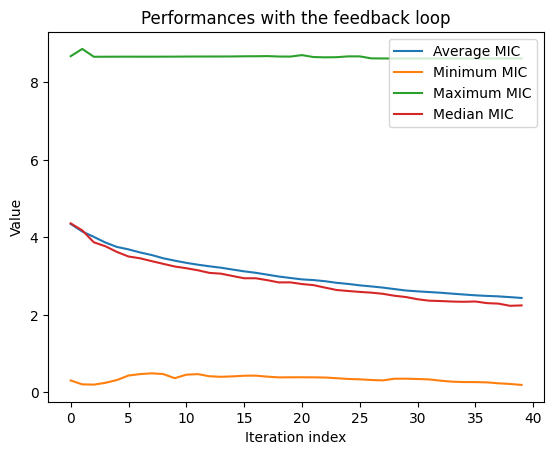

<Figure size 640x480 with 0 Axes>

In [17]:
display({"Average MIC" : average_mic_train, "Minimum MIC" : min_mic_train, "Maximum MIC" : max_mic_train, "Median MIC" : median_mic_train})
plt.savefig("All_MIC.png")

In [14]:
targets = species_vocal[1:]
target_onehot = np.zeros(326 * len(targets)).reshape(len(targets), 326)
for i in range(len(targets)):
  target_onehot[i][np.where(species_vocal==targets[i])[0][0]]=1
generated_sequences = generator.predict(target_onehot, verbose=0)
MIC = oracle.predict([generated_sequences, target_onehot], verbose=0).flatten()
Seq = onehot2seq(generated_sequences)
display_table = pd.DataFrame([species_vocal[1:], Seq, MIC]).transpose()
print(display_table.to_string())

                                         0                  1         2
0                        Bacillus_subtilis    GVlKLLKKFLKFAKI  1.792013
1                    Staphylococcus_aureus  TVyLLLKKFKKFAKDAI  2.636046
2                         Escherichia_coli  TVyLkNKKkKKFAKDAI  0.757396
3                   Pseudomonas_aeruginosa         TVKKLFIFLL   3.09396
4                         Candida_albicans    TVlKLFKFFKLFAKI  4.174263
5               Pectobacterium_carotovorum      TVKKLFIFFLLKI  4.153943
6                Clavibacter_michiganensis    GVlKLLKKFKKFAKI  1.170207
7                    Pseudomonas_corrugata    TVlLkDKKFKLFAKI  0.619942
8                     Pseudomonas_syringae  TVyLkNKKkKKFAKDAI  0.552468
9                  Xanthomonas_vesicatoria  TVyLkNKKkKLFAKDAI  0.337618
10                   Klebsiella_pneumoniae    GVlKLLKKFKKFAKI  1.488182
11              Staphylococcus_epidermidis   GVyKLLKKFKKFAKAI  1.383802
12                    Candida_parapsilosis  TVyLLLKKFKKFAKDAI   

In [19]:
display_table.to_csv("bacteria2peptide.csv")

In [20]:
generator.save("bact2seq_generator.keras")